# Load Packages and Define Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
from collections import defaultdict
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, export_graphviz
from statsmodels.stats.outliers_influence import variance_inflation_factor
from lightgbm import LGBMClassifier
random.seed(1)

In [2]:
NORMALIZE='std'# min, std, False
UNCORR_SELECTION=False # whether to select feature before rf model using correlation between features
CORR_SELECTION=False # whether to select feature before rf model using correlation between features and response
VIF_SELECTION=False # whether to select feature before rf model using VIF
N_EST_CANDI=[20,50,100] #possible number of tree estimators
DEPTH_CANDI=[10,20,30] #possible depth 
N_FEATURE=30 #number of selected features
N_RFE=100 #number of times to run rfe

In [3]:
def check_dup_missing(dat):
    '''check duplication and missing data'''
    print(('Number of duplications:', sum(dat.duplicated())))
    missing = dat.isnull().sum()
    print(('Number of missing entries:', sum(missing)))

In [4]:
def norm(dat, normalize):
    '''normalize data and discard useless data'''
    if normalize=='min':
        co_names = list(dat.columns)
        co_names.remove('family')
        co_names.remove('year')
        co_names.remove('infest_level')
        dat_norm = dat
        dat_norm[co_names] = (dat[co_names]-dat[co_names].min())/(dat[co_names].max()-dat[co_names].min())
        (dat_norm.head())
    elif normalize=='std':
        co_names = list(dat.columns)
        co_names.remove('family')
        co_names.remove('year')
        co_names.remove('infest_level')
        dat_norm = dat
        dat_norm[co_names] = (dat[co_names]-dat[co_names].mean())/(dat[co_names].std())
        (dat_norm.head())
        dat_norm = dat
    else:
        dat_norm = dat
    dat_norm = dat_norm.iloc[0:184,:]
    return dat_norm

In [5]:
def split(dat_norm):
    '''split train testing data set'''
    train, test = train_test_split(dat_norm, test_size=0.2)
    y_train = np.array(train.iloc[:,0])
    X_train = np.array(train.iloc[:,1:])
    y_test = np.array(test.iloc[:,0])
    X_test = np.array(test.iloc[:,1:])
    fea = list(dat_norm.columns)
    return X_train, y_train, X_test, y_test, fea

In [6]:
def uncor_selector(X, y):
    '''select feature that is not highly correlated with other features'''
    feature_name = fea[1:]
    fea_list = set([i for i in range(len(feature_name))])
    for i in range(len(feature_name)):
        if i in fea_list:
            for j in fea_list.copy():
                if j<i and np.abs(np.corrcoef(X[:,i], X[:,j])[0,1])>0.8:
                    cor_i = np.abs(np.corrcoef(X[:,i], y=='Uninfested')[0,1])
                    cor_j = np.abs(np.corrcoef(X[:,j], y=='Uninfested')[0,1])
                    if cor_i>cor_j:
                        try:
                            fea_list.remove(j)
                        except:continue
                    else:
                        try:
                            fea_list.remove(i)
                        except:continue
    return list(fea_list)

def cor_selector(X, y, f, num_feats):
    '''select features that is more correlated with response variable'''
    cor_list = []
    for i in range(len(f)):
        cor = np.corrcoef(X[:,f[i]], y=='Uninfested')[0,1]
        cor_list.append(np.abs(cor))
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = np.argsort(cor_list)[0:min([num_feats,147])]
    return [f[i] for i in cor_feature]

def vif_selector(X, fea_cur):
    '''select feature that has smaller VIF'''
    thresh = 5
    vif = [variance_inflation_factor(X[:, fea_cur], i) for i in range(len(fea_cur))]
    for i in range(1, len(fea_cur)):
        a = np.argmax(vif)
        if vif[a]<thresh:
            break
        fea_cur.pop(a)
        vif = [variance_inflation_factor(X[:, fea_cur], i) for i in range(len(fea_cur))]
    return fea_cur

def print_cor_features(X_train, f):
    if UNCORR_SELECTION or CORR_SELECTION or VIF_SELECTION:
        print('Highly correlated features (corr>0.95) before selection:')
        X = np.array(X_train, dtype=float)
        for i in range(X.shape[1]):
            for j in range(i+1, X.shape[1]):
                cor = np.corrcoef(X[:,i], X[:,j])[0,1]
                if cor>0.95:print((i,j))
        print('Highly correlated features (corr>0.95) after selection:')
        X = np.array(X_train[:,f], dtype=float)
        for i in range(X.shape[1]):
            for j in range(i+1,X.shape[1]):
                cor = np.corrcoef(X[:,i], X[:,j])[0, 1]
                if cor>0.95:print((i,j))
                    
def select_uncorr_fea(X_train, fea):
    '''Selecting feature based on corr/vif'''
    X = np.array(X_train, dtype=float)
    f = [i for i in range(len(fea)-1)]
    if UNCORR_SELECTION:
        f = uncor_selector(X, y_train)
        f.sort()
    if CORR_SELECTION:
        f = cor_selector(X, y_train, f, 159)
        f.sort()
    if VIF_SELECTION:
        f = vif_selector(X, f)
        f.sort()
    if UNCORR_SELECTION or CORR_SELECTION or VIF_SELECTION:
        print('Selected Features:', (f))
        print_cor_features(X_train, f)
    return f

In [7]:
def rf_cv(X_train, y_train, folds=147):
    '''Tune parameters usinng cross validation'''
    best_acc = float('-inf')
    for n_est in N_EST_CANDI:
        for depth in DEPTH_CANDI:
            rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, 
                                        criterion='gini', random_state=10)
            cv = KFold(n_splits=folds, shuffle=False)
            res = np.mean(cross_val_score(rf, X_train, y_train, cv=cv, scoring = 'accuracy'))
            if res>best_acc:
                best_n_est = n_est
                best_depth = depth
                best_acc = res
    print('Best number of trees:', best_n_est, 'Best maximum depth:', best_depth)
    print(('Validation accuracy:', best_acc))
    return best_n_est, best_depth

In [8]:
def rf(X_train, y_train, X_test, y_test, best_n_est=20, best_depth=20):
    '''fit random forest model and return predictions'''
    rf = RandomForestClassifier(n_estimators=best_n_est, max_depth=best_depth,
                                criterion='gini', random_state=11)
    rf.fit(X_train,y_train)
    pred = rf.predict(X_test)
    prob = rf.predict_proba(X_test)
    return prob, pred

In [9]:
def calculate_acc(pred, y_test):
    '''calculate accuracy for each class'''
    count=[[0]*3 for _ in range(3)]
    classes=['Uninfested', 'Low', 'High']
    for i in range(len(pred)):
        count[classes.index(y_test[i])][classes.index(pred[i])]+=1
    count_cls=[sum(c) for c in count]
    acc=[[count[i][j]/count_cls[i] for j in range(3)] for i in range(3)]
    print(('Testing accuracy for all classes:',(count[0][0]+count[1][1]+count[2][2])/sum(count_cls)))
    print(('Testing accuracy for uninfested class:',acc[0][0]))
    print(('Testing accuracy for low infested class:',acc[1][1]))
    print(('Testing accuracy for high infested class:',acc[2][2]))
    return count, acc

def his_freq(count, acc, merge=True):
    '''plot empirical frequency histogram for each class'''
    classes=['Uninfested', 'Low', 'High']
    barWidth = 0.25
    fig = plt.subplots(figsize =(9, 6))
    br1 = np.arange(3)
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    plt.bar(br1, count[0], color ='r', width = barWidth,
            edgecolor ='grey', label ='Uninfested')
    plt.bar(br2, count[1], color ='g', width = barWidth,
            edgecolor ='grey', label ='Low')
    plt.bar(br3, count[2], color ='b', width = barWidth,
            edgecolor ='grey', label ='High')
    plt.xlabel('Predicted infest level', fontweight ='bold', fontsize = 15)
    plt.ylabel('Count of predicted infest level', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(3)],classes)
    plt.gca().set(title='Count of Predicted Class for Different Infest Levels');
    plt.legend()
    plt.show()

In [10]:
def rf_fea_importance(rf, fea):
    '''get feature importance from a fitted rf model, plot and save importance histogram'''
    imp = list(rf.feature_importances_)
    fea_im = [(feature, importance) for feature, importance in zip(fea[1:], imp)]
    fea_im = sorted(fea_im, key=lambda x:x[1], reverse=True)[0:30]
    xx = list(range(len(fea_im)))
    plt.bar(xx, np.array(fea_im)[:,1], orientation='vertical')
    plt.xticks(xx, np.array(fea_im)[:,0], rotation='vertical')
    plt.ylabel('Importance of feature')
    plt.savefig('Feature_importance.png', bbox_inches='tight', pad_inches=0.15)


In [11]:
def rfe(fea, X_train, y_train, step=10, n_features_to_select=30,prt=True):
    '''Recursive Feature Elimination'''
    rfe_selector = RFE(estimator=RandomForestClassifier(), step=step, verbose=0, 
                       n_features_to_select=n_features_to_select)
    rfe_selector.fit(X_train, y_train)
    rfe_support = rfe_selector.get_support()
    rfe_feature = [fea[i+1] for i in range(len(rfe_support)) if rfe_support[i]==True]
    if prt==True:
        print(str(len(rfe_feature)), 'selected features')
        print('Selected Features:', rfe_feature)
    return rfe_feature

In [12]:
def count_rfe_freq(dat_norm, prt=True):
    freq = defaultdict(lambda:0)
    for i in tqdm(range(N_RFE)):
        X_train, y_train, X_test, y_test, fea = split(dat_norm)
        feat = rfe(fea, X_train, y_train, step=10, n_features_to_select=N_FEATURE, prt=False)
        for f in feat:
            freq[f]+=1
    fea_sort = [(k,v) for k, v in sorted(freq.items(), key=lambda item: item[1])][::-1]
    if prt:
        print(fea_sort)
    return fea_sort

def plot_fea(fea_sort, cutoff=50):
    fig = plt.figure(figsize = (10, 5))
    fea_sort=[i for i in fea_sort if i[1]>=cutoff]
    x_tick=[i[0] for i in fea_sort]
    x=[i+1 for i in range(len(fea_sort))]
    y=[i[1] for i in fea_sort]
    plt.bar(x, y, color ='maroon',
            width = 0.4)
    plt.xlabel("Feature Index")
    plt.ylabel("Frequency")
    plt.xticks(x,x_tick)
    #plt.title("Students enrolled in different courses")
    plt.show()
    

# Load Data

In [13]:
# Dataset is already loaded below
os.chdir('D:\\Career\\\DS-ML\\ash_tree\\')
df = pd.read_csv("Compounds_for_Tian.csv")
dat=df.iloc[:,9:204].drop(3).reset_index().transpose().iloc[1:,:]
dat.iloc[:,3:]=dat.iloc[:,3:].astype(float)
smy=df.iloc[3:,0:9]
names=['family','year','infest_level']+[i+1 for i in range(312)]
dat.columns = names
(dat.head())

,family,year,infest_level,1,2,3,4,5,6,7,...,303,304,305,306,307,308,309,310,311,312
1,C,2018,Uninfested,190.750245,472.180854,1547.148264,189.768413,38.256485,458.590228,13.277872,...,32.884819,0.0,0.0,0.0,0.0,0.0,71.465623,642.141079,74.998289,4271.14392
2,C,2018,Uninfested,205.092233,480.025856,1699.110781,166.762426,35.57719,428.683692,3.300284,...,87.580423,0.0,33.014736,122.427017,0.0,2.861174,211.122339,1246.689643,1.074715,10315.04749
3,C,2018,Uninfested,198.488664,364.734072,1208.282758,171.56697,42.906023,513.067172,15.240847,...,54.847208,0.0,0.0,71.927338,0.0,0.0,102.50883,784.492006,78.80647,6222.634886
4,C,2018,Uninfested,205.282883,723.263773,2045.086061,141.431346,27.370308,314.364792,7.610335,...,27.222003,0.0,6.104755,106.002083,1.940932,2.785245,182.506375,1219.676237,90.302976,9054.190361
5,C,2018,Uninfested,194.405033,267.565488,1710.778834,272.759061,69.83358,740.539732,18.367785,...,81.73244,0.0,11.161716,71.998542,0.0,0.0,147.783101,1043.399963,11.845275,7922.380446


# Random Forest Fitting with All Classes

In [14]:
check_dup_missing(dat)
dat_norm = norm(dat,NORMALIZE)
dat_norm = pd.get_dummies(dat_norm, columns=['family','year'])
X_train, y_train, X_test, y_test, fea = split(dat_norm)
#f=select_uncorr_fea(X_train, fea)
#fea=[fea[i] for i in f]

('Number of duplications:', 0)
('Number of missing entries:', 0)


In [15]:
best_n_est, best_depth = rf_cv(X_train, y_train, folds=147)

Best number of trees: 50 Best maximum depth: 10
('Validation accuracy:', 0.5782312925170068)


('Testing accuracy for all classes:', 0.6216216216216216)
('Testing accuracy for uninfested class:', 0.5)
('Testing accuracy for low infested class:', 0.7272727272727273)
('Testing accuracy for high infested class:', 0.4)


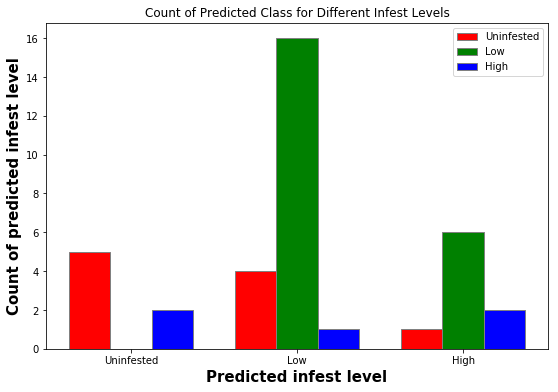

In [16]:
prob, pred = rf(X_train, y_train, X_test, y_test, best_n_est=best_n_est, best_depth=best_depth)
count, acc = calculate_acc(pred, y_test)
his_freq(count, acc)

In [17]:
rfe_feature = rfe(fea, X_train, y_train, step=10, n_features_to_select=30)

30 selected features
Selected Features: [1, 2, 5, 8, 10, 11, 25, 27, 41, 43, 53, 88, 106, 121, 149, 150, 161, 166, 182, 183, 209, 211, 213, 226, 255, 259, 261, 296, 297, 303]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [19:04<00:00, 11.51s/it]


[(96, 100), (41, 100), (2, 100), (11, 97), (259, 96), (150, 95), (10, 92), (182, 90), (149, 89), (183, 85), (27, 84), (53, 82), (303, 76), (121, 74), (296, 71), (166, 66), (261, 65), (283, 65), (1, 64), (280, 61), (242, 61), (226, 61), (43, 59), (211, 54), (40, 47), (8, 44), (282, 42), (125, 42), (312, 41), (310, 41), (25, 37), (14, 36), (106, 34), (144, 32), (300, 31), (255, 31), (15, 29), (86, 28), (209, 28), (88, 27), (68, 24), (162, 24), (153, 23), (84, 22), (268, 22), (152, 21), (5, 21), (257, 20), (44, 20), (137, 19), (82, 17), (179, 16), (113, 15), (161, 15), (294, 15), (141, 14), (81, 14), (123, 13), (107, 13), (98, 11), (115, 11), (214, 11), (42, 10), (6, 10), (213, 9), (146, 9), (45, 8), (256, 8), (52, 5), (30, 5), (108, 5), (55, 5), (32, 4), (260, 4), (49, 4), (124, 4), (33, 4), (23, 4), (51, 4), (129, 3), (37, 3), (297, 3), (193, 3), (272, 3), (119, 3), (36, 3), (277, 3), (17, 3), (216, 2), (63, 2), (246, 2), (4, 2), (39, 1), (167, 1), (217, 1), (286, 1), (239, 1), (20, 1),

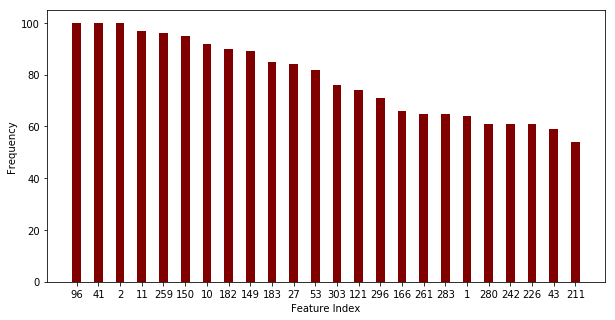

In [18]:
fea_sort = count_rfe_freq(dat_norm)
plot_fea(fea_sort)

# Regression for Y class

In [19]:
check_dup_missing(dat)
dat_Y = norm(dat,NORMALIZE)
dat_Y=dat_Y.loc[dat_Y.family=='Y'].drop('family', axis=1)
dat_Y = pd.get_dummies(dat_Y, columns=['year'])
X_train_Y, y_train_Y, X_test_Y, y_test_Y, fea_Y = split(dat_Y)

('Number of duplications:', 0)
('Number of missing entries:', 0)


In [20]:
best_n_est_Y, best_depth_Y = rf_cv(X_train_Y, y_train_Y, folds=60)

Best number of trees: 100 Best maximum depth: 10
('Validation accuracy:', 0.55)


('Testing accuracy for all classes:', 0.4)
('Testing accuracy for uninfested class:', 0.6)
('Testing accuracy for low infested class:', 0.25)
('Testing accuracy for high infested class:', 0.3333333333333333)


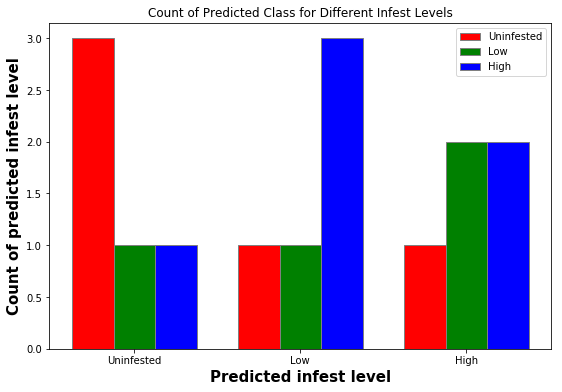

In [21]:
prob_Y, pred_Y = rf(X_train_Y, y_train_Y, X_test_Y, y_test_Y, best_n_est=best_n_est_Y, best_depth=best_depth_Y)
count_Y, acc_Y = calculate_acc(pred_Y, y_test_Y)
his_freq(count_Y, acc_Y)

In [22]:
rfe_feature_Y = rfe(fea_Y, X_train_Y, y_train_Y, step=10, n_features_to_select=30)

30 selected features
Selected Features: [2, 5, 8, 9, 10, 11, 14, 15, 23, 27, 36, 37, 40, 41, 43, 53, 67, 81, 82, 86, 96, 125, 137, 138, 149, 153, 183, 193, 218, 259]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [16:23<00:00, 12.69s/it]


[(2, 100), (259, 99), (11, 92), (149, 85), (15, 81), (53, 80), (150, 78), (125, 73), (153, 72), (41, 72), (137, 71), (183, 70), (40, 66), (280, 63), (296, 60), (152, 59), (182, 58), (14, 56), (10, 52), (282, 49), (166, 49), (43, 49), (27, 48), (82, 47), (8, 46), (86, 46), (213, 44), (121, 43), (33, 41), (300, 40), (211, 40), (189, 39), (294, 39), (5, 39), (303, 36), (174, 35), (144, 34), (36, 34), (310, 33), (96, 33), (39, 31), (3, 30), (25, 27), (6, 26), (37, 24), (269, 23), (138, 23), (81, 22), (133, 21), (67, 21), (84, 20), (214, 17), (242, 17), (261, 15), (226, 15), (112, 14), (146, 14), (76, 14), (32, 13), (187, 13), (83, 12), (44, 12), (286, 12), (42, 11), (135, 11), (193, 10), (85, 10), (277, 10), (23, 10), (68, 10), (215, 9), (173, 9), (175, 9), (4, 9), (290, 8), (190, 8), (219, 8), (115, 7), (255, 7), (209, 7), (80, 7), (312, 6), (270, 6), (239, 6), (283, 5), (297, 5), (89, 5), (217, 5), (128, 5), (179, 5), (113, 4), (256, 4), (1, 4), (288, 4), (233, 4), (250, 4), (124, 4), (9

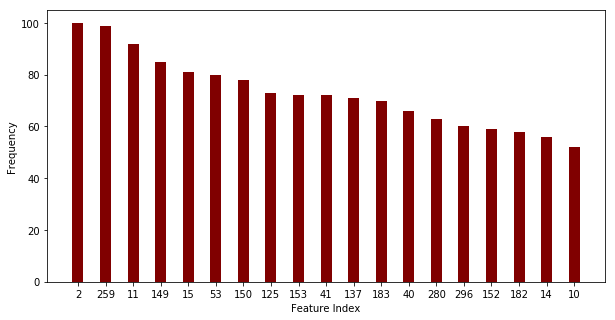

In [23]:
fea_sort_Y = count_rfe_freq(dat_Y)
plot_fea(fea_sort_Y)

# Regression on Z class

In [24]:
check_dup_missing(dat)
dat_Z = norm(dat,NORMALIZE)
dat_Z=dat_Z.loc[dat_Z.family=='Z'].drop('family', axis=1)
dat_Z = pd.get_dummies(dat_Z, columns=['year'])
X_train_Z, y_train_Z, X_test_Z, y_test_Z, fea_Z = split(dat_Z)

('Number of duplications:', 0)
('Number of missing entries:', 0)


In [25]:
best_n_est_Z, best_depth_Z = rf_cv(X_train_Z, y_train_Z, folds=53)

Best number of trees: 20 Best maximum depth: 10
('Validation accuracy:', 0.5849056603773585)


('Testing accuracy for all classes:', 0.5)
('Testing accuracy for uninfested class:', 0.0)
('Testing accuracy for low infested class:', 0.6)
('Testing accuracy for high infested class:', 0.3333333333333333)


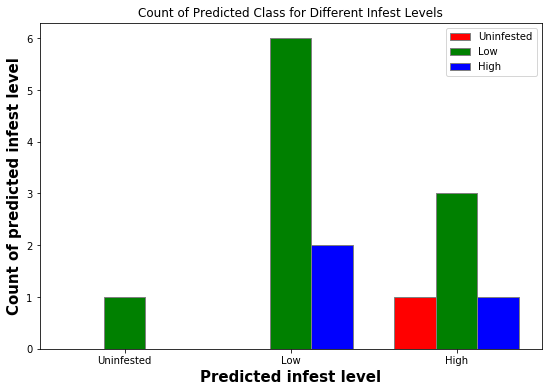

In [26]:
prob_Z, pred_Z = rf(X_train_Z, y_train_Z, X_test_Z, y_test_Z, best_n_est=best_n_est_Z, best_depth=best_depth_Z)
count_Z, acc_Z = calculate_acc(pred_Z, y_test_Z)
his_freq(count_Z, acc_Z)

In [27]:
rfe_feature_Z = rfe(fea_Z, X_train_Z, y_train_Z, step=10, n_features_to_select=30)

30 selected features
Selected Features: [1, 2, 8, 10, 11, 27, 40, 41, 42, 45, 49, 51, 55, 81, 90, 96, 98, 107, 108, 113, 123, 141, 150, 179, 180, 226, 259, 283, 303, 305]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [22:27<00:00, 11.51s/it]


[(96, 100), (10, 100), (283, 99), (11, 98), (2, 97), (41, 94), (123, 86), (51, 83), (107, 76), (310, 70), (303, 65), (27, 63), (276, 61), (108, 61), (113, 54), (120, 53), (259, 49), (149, 49), (98, 49), (257, 48), (226, 48), (246, 45), (40, 45), (93, 42), (55, 42), (305, 40), (88, 39), (312, 38), (49, 38), (141, 37), (183, 37), (106, 36), (238, 35), (256, 34), (182, 33), (233, 31), (81, 30), (9, 29), (14, 28), (24, 26), (45, 25), (5, 25), (44, 24), (119, 24), (270, 23), (109, 22), (179, 22), (133, 21), (150, 19), (90, 19), (16, 19), (161, 18), (62, 18), (82, 18), (242, 17), (209, 17), (53, 16), (300, 16), (68, 16), (94, 15), (89, 14), (42, 13), (309, 12), (86, 12), (203, 12), (272, 11), (274, 11), (279, 11), (219, 11), (84, 11), (135, 11), (144, 10), (255, 10), (35, 10), (43, 10), (134, 9), (77, 9), (6, 9), (159, 8), (8, 8), (38, 8), (37, 7), (30, 7), (269, 7), (103, 7), (140, 6), (70, 6), (162, 6), (230, 6), (180, 6), (285, 6), (111, 6), (115, 6), (1, 5), (220, 5), (22, 5), (216, 5), 

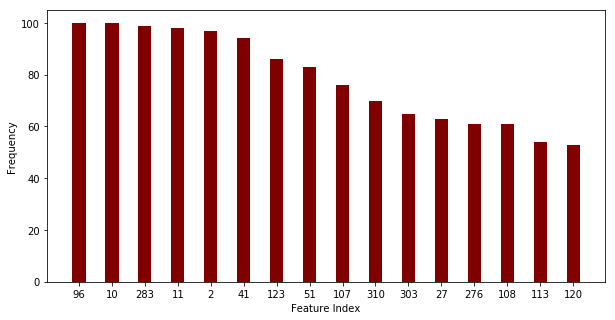

In [28]:
fea_sort_Z = count_rfe_freq(dat_Z)
plot_fea(fea_sort_Z)

# Draft (Do not run)

In [27]:
ct=0
for i in rfe_feature_Y:
    if i in rfe_feature_Z:
        ct+=1
print('Percent of overlap features:',ct/len(rfe_feature_Y))

ct=0
for i in rfe_feature:
    if i in rfe_feature_Z:
        ct+=1
print('Percent of overlap features:',ct/len(rfe_feature))

ct=0
for i in rfe_feature:
    if i in rfe_feature_Y:
        ct+=1
print('Percent of overlap features:',ct/len(rfe_feature))

Percent of overlap features: 0.23333333333333334
Percent of overlap features: 0.3
Percent of overlap features: 0.5333333333333333


# Random Forest Feature Selection with Uncorrelated Variables

Below is random forest using features that are selected by Corr and VIF. However, feature selection using both Corr/VIF and random forest is not better than using random forest alone. So feature selected by previous block is enough for explanation.

In [13]:
N_EST_CANDI=[20,50,100]
DEPTH_CANDI=[10,20,30]
best_acc=float('-inf')

for n_est in N_EST_CANDI:
    for depth in DEPTH_CANDI:
        rf=RandomForestClassifier(n_estimators=n_est,max_depth=depth,criterion='gini',random_state=10)
        cv=KFold(n_splits=147,shuffle=False)
        res=np.mean(cross_val_score(rf,X_train[:,f],y_train,cv=cv,scoring='accuracy'))
        if res>best_acc:
            best_n_est=n_est
            best_depth=depth
            best_acc=res
print('Best number of trees:',best_n_est,'Best maximum depth:',best_depth)
print(('Validation accuracy:',best_acc))

Best number of trees: 100 Best maximum depth: 10
('Validation accuracy:', 0.6394557823129252)


In [14]:
#After make sure the model is good, we preceed to do training and prediction
rf=RandomForestClassifier(n_estimators=200,max_depth=best_depth,criterion='gini',random_state=10)
rf.fit(X_train[:,f],y_train)
pred=rf.predict(X_test[:,f])
prob=rf.predict_proba(X_test[:,f])
acc=[pred[i]==y_test[i] for i in range(len(pred))]
print(('Testing accuracy:',metrics.accuracy_score(y_test, pred)))

('Testing accuracy:', 0.5675675675675675)


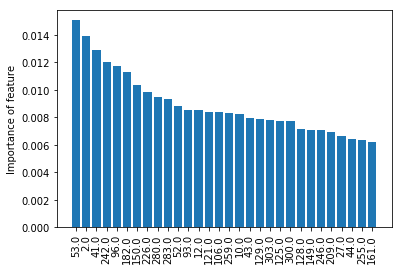

In [15]:
#this is the feature importance
imp=list(rf.feature_importances_)
fea_im=[(feature, importance) for feature, importance in zip(fea[1:],imp)]
fea_im=sorted(fea_im,key=lambda x:x[1],reverse=True)[0:30]
#print(list(fea_im[0:20]))

xx=list(range(len(fea_im)))
#fea_im.reverse()\

plt.bar(xx,np.array(fea_im)[:,1],orientation='vertical')
plt.xticks(xx,np.array(fea_im)[:,0],rotation='vertical')
plt.ylabel('Importance of feature')

plt.savefig('Feature_importance.png',bbox_inches='tight',pad_inches=0.15)

In [16]:
#Recursive Feature Elimination
rfe_selector = RFE(estimator=RandomForestClassifier(), step=10, verbose=5,n_features_to_select=30)
rfe_selector.fit(X_train[:,list(f)], y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = [fea[i+1] for i in range(len(rfe_support)) if rfe_support[i]==True]
print(str(len(rfe_feature)), 'selected features')
print('Selected Features:',rfe_feature)

Fitting estimator with 318 features.
Fitting estimator with 308 features.
Fitting estimator with 298 features.
Fitting estimator with 288 features.
Fitting estimator with 278 features.
Fitting estimator with 268 features.
Fitting estimator with 258 features.
Fitting estimator with 248 features.
Fitting estimator with 238 features.
Fitting estimator with 228 features.
Fitting estimator with 218 features.
Fitting estimator with 208 features.
Fitting estimator with 198 features.
Fitting estimator with 188 features.
Fitting estimator with 178 features.
Fitting estimator with 168 features.
Fitting estimator with 158 features.
Fitting estimator with 148 features.
Fitting estimator with 138 features.
Fitting estimator with 128 features.
Fitting estimator with 118 features.
Fitting estimator with 108 features.
Fitting estimator with 98 features.
Fitting estimator with 88 features.
Fitting estimator with 78 features.
Fitting estimator with 68 features.
Fitting estimator with 58 features.
Fittin

# LGBMClassifier

In [ ]:
lgbc=LGBMClassifier(n_estimators=200, learning_rate=0.05, num_leaves=2, colsample_bytree=0.2,
            reg_alpha=1, reg_lambda=1, min_split_gain=0.001, min_child_weight=4)
cv=KFold(n_splits=147,shuffle=True,random_state=1)
res=cross_val_score(lgbc,X_train,y_train,cv=cv,scoring='accuracy')
print(('Validation accuracy:',np.mean(res)))

In [ ]:
#After make sure the model is good, we preceed to do training and prediction
lgbc.fit(X_train,y_train)
pred=lgbc.predict(X_test)
prob=lgbc.predict_proba(X_test)
acc=[pred[i]==y_test[i] for i in range(len(pred))]
print(('Testing accuracy:',metrics.accuracy_score(y_test, pred)))

In [ ]:
#this is the feature importance
imp=list(lgbc.feature_importances_)
fea_im=[(feature, importance) for feature, importance in zip(fea[1:],imp)]
fea_im=sorted(fea_im,key=lambda x:x[1],reverse=True)[0:20]
#print(list(fea_im[0:20]))

xx=list(range(len(fea_im)))
#fea_im.reverse()\


plt.bar(xx,np.array(fea_im)[:,1],orientation='vertical')
plt.xticks(xx,np.array(fea_im)[:,0],rotation='vertical')
plt.ylabel('Importance of feature')

plt.savefig('Feature_importance.png',bbox_inches='tight',pad_inches=0.15)

In [ ]:
#Recursive Feature Elimination
rfe_selector = RFE(estimator=LGBMClassifier(), n_features_to_select=20, step=10, verbose=5)
rfe_selector.fit(X_train, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = [fea[i+1] for i in range(len(rfe_support)) if rfe_support[i]==True]
print(str(len(rfe_feature)), 'selected features')
print('Selected Features:',rfe_feature)

# XGBoost and Feature Selection

# SVM

In [ ]:
clf = svm.SVC(kernel='rbf') 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Testing accuracy:",metrics.accuracy_score(y_test, y_pred))